In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def poisson_likelihood(s, b, N):
    """ Compute the Poisson likelihood for given signal (s) and background (b). """
    return (s + b)**N * np.exp(-(s + b)) / np.math.factorial(N)

In [23]:
def feldman_cousins_poisson(N, b, confidence_level=0.95, resolution=0.01):
    """ 
    Compute Feldman-Cousins confidence interval for Poisson-distributed data with background.

    Arguments:
    - N: number of observed events
    - b: background count
    - confidence_level: desired confidence level (default is 0.95)
    - resolution: desired resolution for the mu scan
    
    Returns:
    - lower_limit, upper_limit: bounds of the confidence interval
    """
    # Initial values for limits
    lower_limit, upper_limit = -1, -1
    
    # Scan through mu values, starting from 0 upwards
    mu = 0
    while lower_limit == -1 or upper_limit == -1:
        # Preallocate arrays for likelihoods and Rs
        likelihoods = np.zeros(5 * N + 5)
        Rs = np.zeros(5 * N + 5)
        
        # Compute likelihood and R values for each n
        for n in range(5 * N + 5):
            mu_best = max(0, n - b)  # Best estimate of signal for this n
            likelihoods[n] = poisson_likelihood(mu, b, n)
            Rs[n] = likelihoods[n] / poisson_likelihood(mu_best, b, n)

        # Sort by R values in descending order
        sorted_indices = np.argsort(Rs)[::-1]

        # Accumulate likelihoods and find the range of valid n values
        total_likelihood = 0
        valid_indices = []
        for idx in sorted_indices:
            total_likelihood += likelihoods[idx]
            valid_indices.append(idx)

            if total_likelihood >= confidence_level:
                break

        # If no valid indices found, increase mu and try again
        if len(valid_indices) == 0:
            mu += resolution
            continue

        # Determine the lower and upper limits
        if lower_limit == -1 and max(valid_indices) >= N:
            lower_limit = mu

        if upper_limit == -1 and min(valid_indices) > N:
            upper_limit = mu

        mu += resolution  # Increment mu for the next scan
    
    return lower_limit, upper_limit

# Example usage:
N = 0
b = 3
confidence_level = 0.6827  # For 1 sigma interval

# Get the Feldman-Cousins confidence interval for signal (mu)
lower_limit, upper_limit = feldman_cousins_poisson(N, b, confidence_level)

print(f"Feldman-Cousins {100*confidence_level}% Confidence Interval for Signal: [{lower_limit:.2f}, {upper_limit:.2f}]")

Feldman-Cousins 68.27% Confidence Interval for Signal: [0.00, 0.12]


In [24]:
# Make a table with basic confidence interval values

from tabulate import tabulate
from tqdm import tqdm

bs = np.arange(0, 3, 0.5)
ns = np.arange(0, 8, 1)
CONFIDENCE_LEVEL = 0.6827

# Initialize the table with headers
headers = [] + [f"b={b}" for b in bs]  # Create headers dynamically
data = []

# Add rows to the data
for n in tqdm(ns):
    row = [f"n={n}"]
    for b in bs:
        lower_limit, upper_limit = feldman_cousins_poisson(n, b, CONFIDENCE_LEVEL)
        row.append(f"[{lower_limit:.2f},{upper_limit:.2f}]")  # You can replace this with your desired logic
    data.append(row)

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


In [25]:
# Print the table
print(tabulate(data, headers=headers, tablefmt="grid"))

+-----+--------------+-------------+-------------+-------------+-------------+-------------+
|     | b=0.0        | b=0.5       | b=1.0       | b=1.5       | b=2.0       | b=2.5       |
+=====+==============+=============+=============+=============+=============+=============+
| n=0 | [0.00,1.30]  | [0.00,0.81] | [0.00,0.55] | [0.00,0.32] | [0.00,0.15] | [0.00,0.25] |
+-----+--------------+-------------+-------------+-------------+-------------+-------------+
| n=1 | [0.37,2.76]  | [0.00,2.26] | [0.00,1.76] | [0.00,1.32] | [0.00,0.97] | [0.00,0.69] |
+-----+--------------+-------------+-------------+-------------+-------------+-------------+
| n=2 | [0.74,4.26]  | [0.45,3.76] | [0.15,3.26] | [0.00,2.76] | [0.00,2.26] | [0.00,1.80] |
+-----+--------------+-------------+-------------+-------------+-------------+-------------+
| n=3 | [1.11,5.31]  | [0.81,4.81] | [0.55,4.31] | [0.32,3.81] | [0.00,3.31] | [0.00,2.81] |
+-----+--------------+-------------+-------------+-------------+------

In [3]:
def gaussian_likelihood(x, mu):
    """ Compute the Gaussian likelihood for a given signal (mu). """
    return (1 / np.sqrt(2 * np.math.pi)) * np.exp((-(x - mu)**2) / 2)

def gaussian_R(x, mu):
    """ Compute the Gaussian r-value for a given signal (mu). """
    if x < 0:
        return np.exp(x*mu - ((mu**2) / 2))
    return np.exp(-((x - mu)**2) / 2)

In [5]:
gaussian_likelihood(0, 2)

0.05399096651318806

In [4]:
def feldman_cousins_gaussian(X, confidence_level=0.95, resolution=0.01):
    """ Compute Feldman-Cousins confidence interval for Poisson-distributed data with background.
    
    Arguments:
    - x: number of observed events
    - confidence_level: desired confidence level (default is 0.95)
    - resolution: desired resolution
    
    Returns:
    - lower_limit, upper_limit: bounds of the confidence interval
    """
    
    lower_limit, upper_limit = -1, -1
    
    mu = 0
    while lower_limit == -1 or upper_limit == -1:
        likelihoods = np.array([])
        Rs = np.array([])
        Xs = np.arange(X - 10,X + 10, resolution)
    
        for x in Xs:
            mu_best = max(0, x)
            likelihoods = np.append(likelihoods, gaussian_likelihood(x, mu))
            Rs = np.append(Rs, gaussian_likelihood(x, mu) / gaussian_likelihood(x, mu_best))
        
        sorted_indices = sorted(range(len(Rs)), key=lambda i: Rs[i], reverse=True)
        
        total_likelihood = 0
        valid_indices = []
        for idx in sorted_indices:
            total_likelihood += likelihoods[idx] * resolution # shitty numerical integral approximation
            valid_indices.append(idx)
            
            if total_likelihood >= confidence_level:
                break
        
        # If no valid indices found, increase mu and try again
        if len(valid_indices) == 0:
            mu += resolution
            continue
        
        if lower_limit == -1 and Xs[max(valid_indices)] >= X:
            lower_limit = mu
        
        if upper_limit == -1 and Xs[min(valid_indices)] > X:
            upper_limit = mu
        
        mu += resolution
    
    return lower_limit, upper_limit
    
# Example usage:
x = -1
confidence_level = 0.9

# Get the Feldman-Cousins confidence interval for signal (mu)
lower_limit, upper_limit = feldman_cousins_gaussian(x, confidence_level)

print(f"Feldman-Cousins {100*confidence_level}% Confidence Interval for Signal: [{round(lower_limit, 4)}, {round(upper_limit, 4)}]")

Feldman-Cousins 90.0% Confidence Interval for Signal: [0, 0.82]


In [5]:
# Make a graph with basic confidence interval values

from tqdm import tqdm

Xs = np.arange(-2, 4, 0.1)
upper_limits = np.array([])
lower_limits = np.array([])

for x in tqdm(Xs):
    lower_limit, upper_limit = feldman_cousins_gaussian(x, 0.9)
    upper_limits = np.append(upper_limits, upper_limit)
    lower_limits = np.append(lower_limits, lower_limit)

100%|███████████████████████████████████████████| 60/60 [03:59<00:00,  3.99s/it]


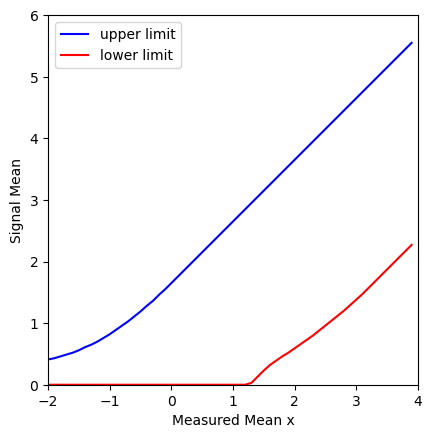

In [7]:
# Plot both sets of y-values against x
plt.plot(Xs, upper_limits, label='upper limit', color='b')  # Plot y1 with label and color
plt.plot(Xs, lower_limits, label='lower limit', color='r')  # Plot y2 with label and color

# Add labels and title
plt.xlabel('Measured Mean x')
plt.ylabel('Signal Mean')

plt.xlim(-2, 4)
plt.ylim(0, 6)

plt.gca().set_aspect('equal', adjustable='box')

# Add a legend to differentiate between the two plots
plt.legend()

# Show the plot
plt.show()

In [ ]:
"""
Next steps:
bounded poisson doesn't work with b > 4
add more generality
improve efficiency! the range should be chosen better

"""